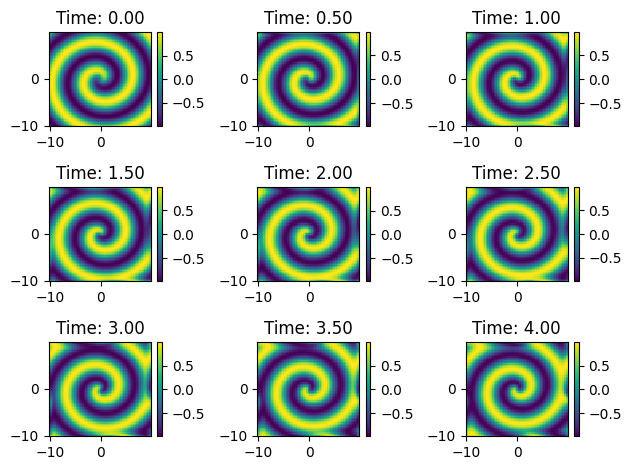

In [78]:
# Part A

import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.linalg import kron

# Initializing Parameters
tspan = np.arange(0, 4.5, 0.5) 
beta = 1
D1 = D2 = 0.1
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

# Defining the spatial domain
x2 = np.linspace(-Lx / 2, Lx / 2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly / 2, Ly / 2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)

#  Initial Conditons
m = 1 # Number of spirals
U0 = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
V0 = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))

# Define spectral k values
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx / 2), np.arange(-nx / 2, 0)))
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny / 2), np.arange(-ny / 2, 0)))
kx[0] = ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

def rhs(t, UVt, nx, ny, N, K, D1, D2, beta):
    # Split U and V
    Ut = UVt[:N].reshape((nx,ny))
    Vt = UVt[N:].reshape((nx,ny))
    
    U = ifft2(Ut)
    V = ifft2(Vt)

    A = U**2 + V**2
    lambda_A = 1 - A**2
    omega_A = -beta * A**2

    rhs_U = fft2(lambda_A * U - omega_A * V) - D1 * K * Ut
    rhs_V = fft2(omega_A * U + lambda_A * V) - D2 * K * Vt

    return np.hstack([rhs_U.ravel(), rhs_V.ravel()])

U0t = fft2(U0)
V0t = fft2(V0)
UV0t = np.hstack([U0t.ravel(), V0t.ravel()])

sol = solve_ivp(rhs, [tspan[0], tspan[-1]], UV0t, method = 'RK45', t_eval=tspan, args=(nx, ny, N, K, D1, D2, beta))

A1 = np.zeros((8192, 9))
for i, t in enumerate(tspan):
    U_hat, V_hat = sol.y[:N, i].reshape((nx, ny)), sol.y[N:, i].reshape((nx, ny))
    U = np.real(ifft2(U_hat))
    V = np.real(ifft2(V_hat))

    A1[:,i] = np.hstack((U.flatten(),V.flatten()))

    plt.subplot(3, 3, i + 1)
    plt.pcolor(x, y, U, shading='auto')
    plt.title(f'Time: {t:.2f}')
    plt.colorbar()
plt.tight_layout()
plt.show()

In [79]:
# Part A Animation Longer solution for animation
tspan2 = np.arange(0, 50.5, 0.5)
sol2 = solve_ivp(rhs, [tspan2[0], tspan2[-1]], UV0t, t_eval=tspan2, args=(nx, ny, N, K, D1, D2, beta))

animlist = []
for i, t in enumerate(tspan2):
    U_hat, V_hat = sol2.y[:nx * ny, i].reshape((nx, ny)), sol2.y[nx * ny:, i].reshape((nx, ny))
    U = np.real(ifft2(U_hat))
    animlist.append(U)

fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolor(X, Y, animlist[-1], shading='auto', cmap='viridis')
fig.colorbar(c, ax=ax)
time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, color='white', fontsize=12)

# Define the update function for the animation
def update(frame):
    # Extract U_hat and compute U for the current frame
    U_hat = sol2.y[:nx * ny, frame].reshape((nx, ny)) + 1j * sol2.y[nx * ny:2 * nx * ny, frame].reshape((nx, ny))
    U = np.real(ifft2(U_hat))
    
    # Update the plot and time text
    c.set_array(U.ravel())
    time_text.set_text(f'Time: {tspan2[frame]:.2f}')
    return c, time_text

# Create the animation
ani = FuncAnimation(fig, update, frames=len(tspan2), interval=100, blit=False)

# Display the animation in the notebook
plt.close(fig)
HTML(ani.to_jshtml())

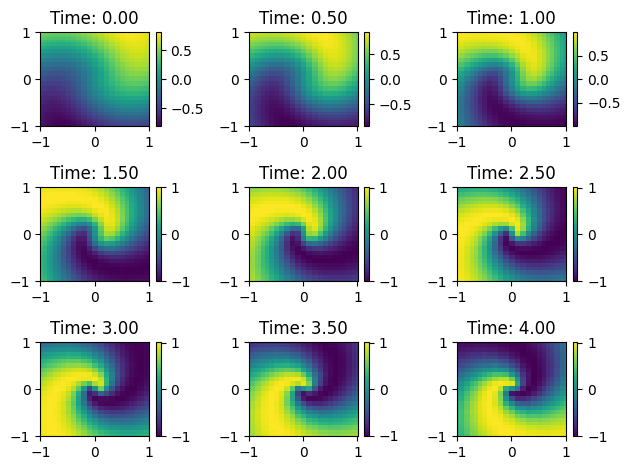

In [ ]:
# Part B Code
tspan = np.arange(0, 4.5, 0.5) 
beta = 1
D1 = D2 = 0.1

def cheb(N):
	if N==0: 
		D = 0.; x = 1.
	else:
		n = np.arange(0,N+1)
		x = np.cos(np.pi*n/N).reshape(N+1,1) 
		c = (np.hstack(( [2.], np.ones(N-1), [2.]))*(-1)**n).reshape(N+1,1)
		X = np.tile(x,(1,N+1))
		dX = X - X.T
		D = np.dot(c,1./c.T)/(dX+np.eye(N+1))
		D -= np.diag(np.sum(D.T, axis=0))
	return D, x.reshape(N+1)

n = 30
D, x = cheb(n)
D[n, :] = 0
D[0, :] = 0
Dsquared = np.dot(D, D) / ()
y = x

I = np.eye(len(Dsquared))
L = kron(I, Dsquared) + kron(Dsquared, I) # 2D Laplacian

X, Y = np.meshgrid(x,y)
m = 1 # Number of spirals
U0 = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
V0 = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
u0 = U0.reshape((n+1) ** 2)
v0 = V0.reshape((n+1) ** 2)
uv0 = np.hstack((u0,v0))



def chebrhs(t, UV, L, beta, D1, D2):
	U = UV[:((n+1)**2)]
	V = UV[((n+1)**2):]
	
	A = U**2 + V**2
	lambda_A = 1 - A**2
	omega_A = - beta * A**2

	rhs_U = lambda_A * U - omega_A * V + D1 * np.dot(L,U)
	rhs_V = omega_A * U + lambda_A * V + D2 * np.dot(L,V)

	return np.hstack([rhs_U, rhs_V])

chebsol = solve_ivp(chebrhs, [tspan[0], tspan[-1]], uv0, method = 'RK45', t_eval=tspan, args=(L, beta, D1, D2))
	
for j, t in enumerate(tspan):
	Ucheb = chebsol.y[:((n+1)**2), j].reshape((n+1, n+1))
	Vcheb = chebsol.y[((n+1)**2):, j].reshape((n+1, n+1))
	plt.subplot(3, 3, j+1)
	plt.pcolor(X, Y, Ucheb, shading='auto')
	plt.title(f'Time: {t:.2f}')
	plt.colorbar()

plt.tight_layout()
plt.show()